<>:137: SyntaxWarning: invalid escape sequence '\p'
<>:137: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1547/3131144203.py:137: SyntaxWarning: invalid escape sequence '\p'
  title = 'Hofstadter Butterfly for $\phi = p / '+ str(self.max_q) + '$ and $W = '+ str(self.disorder) + '$'


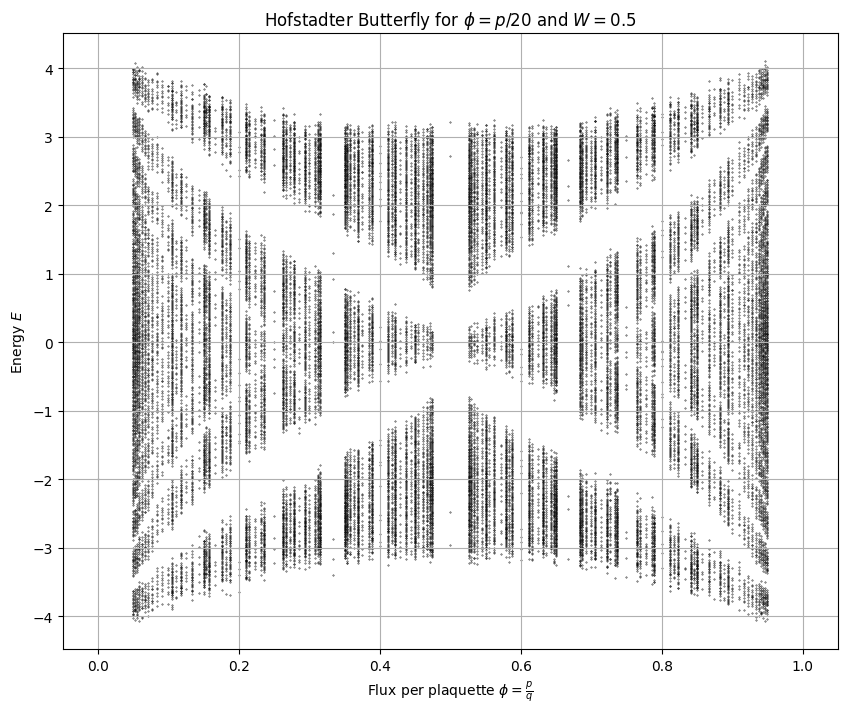

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import gcd
import os


class Square_Hamiltonian:
    """ Square lattice simulation with Anderson localization and a magnetic field"""
    def __init__(self, t: float, W: float, phi: float, max_q: int, save=False):
        """
        Initialize Square Lattice.
        
        Parameters:
            t (float): Hopping parameter
            W (float): Disorder strength
            phi (float): Magnetic flux per plaquette (in units of flux quantum).
            q (int): Maximum denominator for phi values in Hofstadter butterfly.
            save (bool): If True, save plots to disk
        """
        self.t = t
        self.disorder = W
        self.phi = phi
        self.max_q = max_q
        self.save = save

         # Initialize boundary fluxes - these do not contribute to the flux plaquett
        self.phi_x = 0.0  # Flux through x direction
        self.phi_y = 0.0  # Flux through y direction
        
        # Directory handling if saving
        self.lattice_type = "Square"
        if self.save:
            base_dir = os.path.join("plots", self.lattice_type) # Base directory for saving plots

             # Determine subdirectory based on disorder state
             
            if self.disorder == 0:
                sub_dir = os.path.join(base_dir, "No_Disorder",
                                       f"t{self.t}_maxq{self.max_q}")
            else:
                sub_dir = os.path.join(base_dir, "Disorder",
                                       f"t{self.t}_maxq{self.max_q}_W{self.disorder}")
                
            # Set the path and ensure the directory exists
            self.path = sub_dir

            # Create the directory if it doesn't already exist
            os.makedirs(self.path, exist_ok=True)


    def saving(self, title, save=False):
       
        if self.save and save and title is not None:
            plt.savefig(os.path.join(self.path, title + ".png"))
            plt.show()
        else:
            plt.show()

    """ Defining and diagonalizing the Hamiltonian for the system """

    def disorder_setter(self, N):
        # Incorporate the disorder parameter into matrix elements as an on-site disorder potential
        return self.disorder * (2 * np.random.rand(N) - 1)

    def peierls_phase(self, i, j, L, direction):
        """
        Calculate the Peierls phase for hopping between sites.

        Parameters:
            i (int): x-index of the starting site.
            j (int): y-index of the starting site.
            direction (str): 'x' for horizontal hopping, 'y' for vertical hopping.

        Returns:
            complex: exp(i * phase)
        """
        if direction == 'x':
            # Hopping in the x-direction
            phase = 0.0
            if (i + 1) >= L:
                # Boundary hopping in x-direction  
                phase += 2 * np.pi * self.phi_x
            return np.exp(1j * phase)

        elif direction == 'y':
            # Hopping in the y-direction
            phase = 2 * np.pi * self.phi * i
            if (j + 1) >= L:
                # Boundary hopping in y-direction  
                phase += 2 * np.pi * self.phi_y
            return np.exp(1j * phase)


    def construct_hamiltonian(self, p, q):
        """
        Construct the Hamiltonian matrix with hopping,
        Peierls phases, and disorder.

        Returns:
            evals (1D np.array): Eigenvalues of the Hamiltonian
            evecs (2D np.array): Corresponding eigenvectors
        """
        L = q # Set the matrix dimension equal to q (denominator of phi)
        N = L * L # Dimension of adjacency matrix
        self.phi = p / q  # Flux per plaquette

        # Initialize Hamiltonian
        on_site_disorder = self.disorder_setter(N)
        matrix = np.zeros((N, N), dtype=complex)

        for i, j in np.ndindex((L, L)):
            n = i * L + j  # Current site index

            # On-site potential
            matrix[n, n] = on_site_disorder[n]

            # Hopping in x-direction (to site (i+1, j))
            m_x = ((i + 1) % L) * L + j
            phase_x = self.peierls_phase(i, j, L, 'x')
            matrix[n, m_x] = -self.t * phase_x

            # Hopping in y-direction (to site (i, j+1))
            m_y = i * L + ((j + 1) % L)
            phase_y = self.peierls_phase(i, j, L, 'y')
            matrix[n, m_y] = -self.t * phase_y

        # Ensure the Hamiltonian is Hermitian
        H = matrix + matrix.conj().T

        # Compute eigenvalues and eigenvectors
        evals, evecs = np.linalg.eigh(H)
        return evals, evecs

    def plot_hofstadter_butterfly(self, title=None, save=False):
     
        if title is None:
            title = rf'Hofstadter Butterfly for $\phi = p / '+ str(self.max_q) + '$ and $W = '+ str(self.disorder) + '$'
            path = "Hofstadter_Butterfly"

        phis = []
        energies = []

        for q in range(1, self.max_q + 1):
            for p in range(q + 1):
                
                if gcd(p, q) == 1:
                    evals, _ = self.construct_hamiltonian(p, q) # Reconstruct hamiltonian for each allowed phi
                    
                    phis.extend([p / q] * len(evals))
                    energies.extend(evals.tolist())

        plt.figure(figsize=(10, 8))
        plt.scatter(phis, energies, s=0.1, color='black')
        plt.xlabel(r'Flux per plaquette $\phi = \frac{p}{q}$')
        plt.ylabel(r'Energy $E$')
        plt.title(title)
        plt.grid(True)

    def prepare_outputs(self):
        """
        Package all relevant parameters and diagonalization 
        outputs in a tuple to pass onto independent plotting functions.

        Returns:
            tuple: Parameter inputs for plotting functions.
        """
        self.evals, self.evecs = self.construct_hamiltonian()
        
        outputs = (self.t, self.disorder, self.phi, 
                   self.max_q, self.evals, self.evecs, self.lattice_type)
        
        return outputs

model = Square_Hamiltonian(t=1.0, W=0.5, phi = 0.0, max_q=20, save=False)
model.plot_hofstadter_butterfly(save=False)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import gcd
import os

class Honeycomb_Hamiltonian:
    """Honeycomb lattice simulation with Anderson localization and a magnetic field."""

    def __init__(self, t: float, W: float, phi: float, max_q: int, save = False):
        """
        Initialize Honeycomb lattice.
        
        Parameters:
            t (float): Hopping parameter
            W (float): Disorder strength
            phi (float): Magnetic flux per plaquette (in units of flux quantum).
            q (int): Maximum denominator for phi values in Hofstadter butterfly.
            save (bool): If True, save plots to disk
        """
        self.t = t
        self.disorder = W
        self.phi = phi
        self.max_q = max_q
        self.save = save
        
        # Directory handling if saving
        self.lattice_type = 'Honeycomb'
        if self.save:
            base_dir = os.path.join("plots", self.lattice_type) # Base directory for saving plots

             # Determine subdirectory based on disorder state
             
            if self.disorder == 0:
                sub_dir = os.path.join(base_dir, "No_Disorder",
                                       f"t{self.t}_phi{self.phi}_maxq{self.max_q}")
            else:
                sub_dir = os.path.join(base_dir, "Disorder",
                                       f"t{self.t}_phi{self.phi}_maxq{self.max_q}_W{self.disorder}")
                
            # Set the path and ensure the directory exists
            self.path = sub_dir

            # Create the directory if it doesn't already exist
            os.makedirs(self.path, exist_ok=True)
    
    
    def saving(self, title, save = False):
        
        if self.save == True and save == True and title != None:
            plt.savefig(os.path.join(self.path, title+'.png'))
            plt.show()
        else:
            plt.show()

    #  Defining and diagonalizing the Hamiltonian for the system

    def disorder_setter(self, N):
        # Incorporate the disorder parameter into matrix elements as an on-site disorder potential
        return self.disorder * (2 * np.random.rand(N) - 1)

    def peierls_phase(self, delta_x, delta_y, x, y):
        """
        Calculate the Peierls phase.

        Parameters:
            delta_x (int): Change in x-coordinate between sites.
            delta_y (int): Change in y-coordinate between sites.
            x (int): x-coordinate of the starting site.
            y (int): y-coordinate of the starting site.

        Returns:
            complex: Phase factor to be applied to the hopping term.
        """
        # Phase accumulated is phi * x * delta_y
        phase = 2 * np.pi * self.phi * (x * delta_y)
        return np.exp(1j * phase)

    def construct_hamiltonian(self, p, q):
        """
        Construct the Hamiltonian matrix with hopping,
        Peierls phases, and disorder.

        Returns:
            evals (1D np.array): Eigenvalues of the Hamiltonian
            evecs (2D np.array): Corresponding eigenvectors
        """
        L = q # Set the matrix dimension equal to q (denominator of phi)
        N = L * L # Dimension of adjacency matrix
        self.phi = p / q  # Flux per plaquette

        # Initialize Hamiltonian
        on_site_disorder = self.disorder_setter(N)
        matrix = np.zeros((N, N), dtype=complex)

        for i, j in np.ndindex((L, L)):
            n = i * L + j
            A = 2 * n    # Sublattice A index
            B = A + 1    # Sublattice B index

            # On-site potentials
            matrix[A, A] = on_site_disorder[A]
            matrix[B, B] = on_site_disorder[B]

            # Hopping from A to B in the same unit cell
            phase = self.peierls_phase(0, 0, i, j)
            matrix[A, B] = -self.t * phase
            matrix[B, A] = -self.t * np.conj(phase)

            # Horizontal hopping from A to B (delta_x = 1, delta_y = 0)
            i_x = (i + 1) % L
            n_x = i_x * L + j
            B_x = 2 * n_x + 1
            phase = self.peierls_phase(1, 0, i, j)
            matrix[A, B_x] = -self.t * phase
            matrix[B_x, A] = -self.t * np.conj(phase)

            # Vertical hopping from A to B (delta_x = 0, delta_y = 1)
            j_y = (j + 1) % L
            n_y = i * L + j_y
            B_y = 2 * n_y + 1
            phase = self.peierls_phase(0, 1, i, j)
            matrix[A, B_y] = -self.t * phase
            matrix[B_y, A] = -self.t * np.conj(phase)

        # Constructed Hamiltonian
        H = matrix

        # Compute eigenvalues and eigenvectors
        self.evals, self.evecs = np.linalg.eigh(H)

        return self.evals, self.evecs
    
    def plot_hofstadter_butterfly(self, title=None, save=False):
     
        if title is None:
            title = 'Hofstadter Butterfly for $\phi = p / '+ str(self.max_q) + '$ and $W = '+ str(self.disorder) + '$'
            path = "Hofstadter_Butterfly"

        phis = []
        energies = []

        for q in range(1, self.max_q + 1):
            for p in range(q + 1):
                
                if gcd(p, q) == 1:
                    evals, _ = self.construct_hamiltonian(p, q) # Reconstruct hamiltonian for each allowed phi
                    
                    phis.extend([p / q] * len(evals))
                    energies.extend(evals.tolist())

        plt.figure(figsize=(10, 8))
        plt.scatter(phis, energies, s=0.1, color='black')
        plt.xlabel(r'Flux per plaquette $\phi = \frac{p}{q}$')
        plt.ylabel(r'Energy $E$')
        plt.title(title)
        plt.grid(True)

    def prepare_outputs(self):
        """
        Package all relevant parameters and diagonalization 
        outputs in a tuple to pass onto independent plotting functions.

        Returns:
            tuple: Parameter inputs for plotting functions.
        """
        self.evals, self.evecs = self.construct_hamiltonian()
        
        outputs = (self.t, self.disorder, self.phi, 
                   self.max_q, self.evals, self.evecs, self.lattice_type)
        
        return outputs

model = Honeycomb_Hamiltonian(t=1.0, W=0.0, phi = 0.0, max_q=10, save=False)
model.plot_hofstadter_butterfly(save=False)

<>:136: SyntaxWarning: invalid escape sequence '\p'
<>:136: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_1547/1414628384.py:136: SyntaxWarning: invalid escape sequence '\p'
  title = 'Hofstadter Butterfly for $\phi = p / '+ str(self.max_q) + '$ and $W = '+ str(self.disorder) + '$'
/tmp/ipykernel_1547/1414628384.py:136: SyntaxWarning: invalid escape sequence '\p'
  title = 'Hofstadter Butterfly for $\phi = p / '+ str(self.max_q) + '$ and $W = '+ str(self.disorder) + '$'


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from math import gcd
import os

class Triangular_Hamiltonian:
    """ Triangular lattice simulation with Anderson localization and magnetic field """

    def __init__(self, t: float, W: float, phi: float, q: int, save = False):
        """
        Initialize Triangular lattice. 
        
        Parameters:
            t (float): Hopping parameter
            W (float): Disorder strength
            phi (float): Magnetic flux per plaquette (in units of flux quantum).
            q (int): Maximum denominator for phi values in Hofstadter butterfly.
            save (bool): If True, save plots to disk
        """
        self.t = t  # Hopping parameter
        self.disorder = W  # Disorder strength
        self.phi = phi  # Magnetic flux per plaquette
        self.max_q = q  # Maximum denominator for phi values
        self.save = save

        # Directory handling if saving
        self.lattice_type = 'Triangular'
        if self.save:
            # Base directory for saving plots
            base_dir = os.path.join('plots', self.lattice_type)
            
            # Determine subdirectory based on disorder state
            if self.disorder == 0:
                sub_dir = os.path.join(base_dir, 'No_Disorder', f't{self.t}_phi{self.phi}_q{self.max_q}')
            else:
                sub_dir = os.path.join(base_dir, 'Disorder', f't{self.t}_phi{self.phi}_q{self.max_q}_dis{self.disorder}')
            
            # Set the path and ensure the directory exists
            self.path = sub_dir
            
            # Create the directory if it doesn't already exist
            os.makedirs(self.path, exist_ok=True)
    
    
    def saving(self, title, save = False):
        
        if self.save == True and save == True and title != None:
            plt.savefig(os.path.join(self.path, title+'.png'))
            plt.show()
        else:
            plt.show()

    """ Defining and diagonalizing the Hamiltonian for the system """

    def disorder_setter(self, N):
        # Incorporate the disorder parameter into matrix elements as an on-site disorder potential
        return self.disorder * (2 * np.random.rand(N) - 1)

    def peierls_phase(self, i, j, delta_i, delta_j):
        """Calculate Peierls phase factor for hopping between sites.

        Parameters:
        i (int): x-index of starting site
        j (int): y-index of starting site
        delta_i (int): Change in x-coordinate between sites.
        delta_j (int): Change in y-coordinate between sites.

        Returns:
        complex: Phase factor for the hopping term
        """

        # Using the Landau gauge
        # Average x position during hop
        i_avg = i + delta_i / 2

        # Phase accumulated during hop
        phase = np.exp(2j * np.pi * self.phi * i_avg * delta_j)

        return phase

    def construct_hamiltonian(self, p, q):
        """
        Construct the Hamiltonian matrix with hopping,
        Peierls phases, and disorder.

        Returns:
            evals (1D np.array): Eigenvalues of the Hamiltonian
            evecs (2D np.array): Corresponding eigenvectors
        """
        L = q # Set the matrix dimension equal to q (denominator of phi)
        N = L * L # Dimension of adjacency matrix
        self.phi = p / q  # Flux per plaquette

        # Initialize Hamiltonian
        on_site_disorder = self.disorder_setter(N)
        matrix = np.zeros((N, N), dtype=complex)

        for i in range(L):
            for j in range(L):
                n = i * L + j

                # On-site potential
                matrix[n, n] = on_site_disorder[n]

                # List of the six nearest neighbors
                neighbors = [
                    (1, 0),    # Right (+i)
                    (0, 1),    # Up (+j)
                    (-1, 1),   # Up-Left (-i, +j)
                    (-1, 0),   # Left (-i)
                    (0, -1),   # Down (-j)
                    (1, -1)    # Down-Right (+i, -j)
                ]

                for delta_i, delta_j in neighbors:
                    i_neighbor = (i + delta_i) % L
                    j_neighbor = (j + delta_j) % L
                    n_neighbor = i_neighbor * L + j_neighbor

                    # Calculate Peierls phase
                    phase = self.peierls_phase(i, j, delta_i, delta_j)

                    # Add hopping term
                    matrix[n, n_neighbor] += -self.t * phase

        # Ensure Hamiltonian is Hermitian
        H = (matrix + matrix.conj().T) / 2

        # Compute eigenvalues and eigenvectors
        self.evals, self.evecs = np.linalg.eigh(H)

        return self.evals, self.evecs

    def plot_hofstadter_butterfly(self, title=None, save=False):
     
        if title is None:
            title = 'Hofstadter Butterfly for $\phi = p / '+ str(self.max_q) + '$ and $W = '+ str(self.disorder) + '$'
            path = "Hofstadter_Butterfly"

        phis = []
        energies = []

        for q in range(1, self.max_q + 1):
            for p in range(q + 1):
                
                if gcd(p, q) == 1:
                    evals, _ = self.construct_hamiltonian(p, q) # Reconstruct hamiltonian for each allowed phi
                    
                    phis.extend([p / q] * len(evals))
                    energies.extend(evals.tolist())

        plt.figure(figsize=(10, 8))
        plt.scatter(phis, energies, s=0.1, color='black')
        plt.xlabel(r'Flux per plaquette $\phi = \frac{p}{q}$')
        plt.ylabel(r'Energy $E$')
        plt.title(title)
        plt.grid(True)

    def prepare_outputs(self):
        """
        Package all relevant parameters and diagonalization 
        outputs in a tuple to pass onto independent plotting functions.

        Returns:
            tuple: Parameter inputs for plotting functions.
        """
        self.evals, self.evecs = self.construct_hamiltonian()
        
        outputs = (self.t, self.disorder, self.phi, 
                   self.max_q, self.evals, self.evecs, self.lattice_type)
        
        return outputs